In [ ]:
# Install required libraries
#!pip install torch torchvision opencv-python-headless diffusers transformers accelerate

# Clone U2-Net repository and navigate into it
#!git clone https://github.com/xuebinqin/U-2-Net.git
#%cd /content/U-2-Net

# Download pre-trained U2-Net weights
#!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net.pth

# Import libraries
import torch
import torch.nn as nn
import cv2
import numpy as np
import os
from google.colab import drive, files
import matplotlib.pyplot as plt

# U2-Net model import
from model import u2net

# Stable Diffusion import
from diffusers import StableDiffusionPipeline

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load U2-Net model
def load_u2net_model(model_path="saved_models/u2net.pth"):
    net = u2net.U2NET()  # Full U2-Net model
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()
    return net

u2net_model = load_u2net_model()
print("U2-Net model loaded successfully.")

# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to(device)
print("Stable Diffusion model loaded successfully.")

# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval().to(device)
print("MiDaS model loaded successfully.")

# Verify environment setup
print(f"Using device: {device}")
print(f"Current directory: {os.getcwd()}")
print(f"Google Drive mounted at: /content/drive")

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/u2net.pth'

In [ ]:
# Download pre-trained weights (u2net.pth for full model)
!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net.pth

# Load the model
def load_u2net_model(model_path="saved_models/u2net.pth"):
    net = u2net.U2NET()  # Full U2-Net model
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.to(device)
    net.eval()
    return net

u2net_model = load_u2net_model()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=c8c85cce-68f1-41f5-be42-c52cda98dd5f
To: /content/U-2-Net/saved_models/u2net.pth
100% 176M/176M [00:01<00:00, 99.0MB/s]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


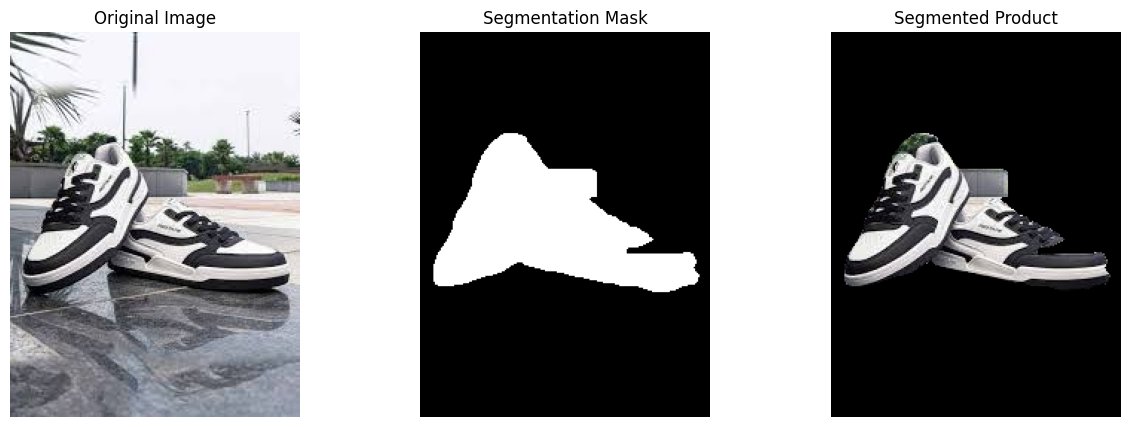

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Set the correct image path inside Google Drive
image_path = "/content/drive/My Drive/Thryft/input_sneaker.jpeg"

# Check if the image exists in Google Drive
if not os.path.exists(image_path):
    raise FileNotFoundError(f"❌ Error: Image not found at '{image_path}'. Check the folder path.")

# Preprocessing function
def preprocess_image(image_path, size=(320, 320)):
    img = cv2.imread(image_path)

    # Error handling if image loading fails
    if img is None:
        raise ValueError(f"❌ Error: Unable to read image at '{image_path}'. Check if the file is corrupted or path is wrong.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_shape = img.shape[:2]
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = img / 255.0  # Normalize to [0, 1]
    img = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0)  # Convert to tensor: [1, C, H, W]

    return img, original_shape

# Segmentation function
def segment_image(model, image_path, device="cpu"):
    # Load and preprocess image
    img_tensor, original_shape = preprocess_image(image_path)
    img_tensor = img_tensor.to(device)

    # Run inference
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = model(img_tensor)  # U2-Net outputs multiple side predictions
        pred = d1[:, 0, :, :]  # Use the first output (most refined)
        pred = (pred - pred.min()) / (pred.max() - pred.min())  # Normalize

    # Post-process mask
    mask = pred.squeeze().cpu().numpy()
    mask = cv2.resize(mask, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_AREA)
    mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary mask

    # Apply mask to original image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    segmented_img = cv2.bitwise_and(original_img, original_img, mask=mask)

    return segmented_img, mask

# Assuming 'u2net_model' is already loaded
device = "cuda" if torch.cuda.is_available() else "cpu"

# Segment the image
segmented_product, product_mask = segment_image(u2net_model, image_path, device)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Segmentation Mask")
plt.imshow(product_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Segmented Product")
plt.imshow(segmented_product)
plt.axis("off")

plt.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

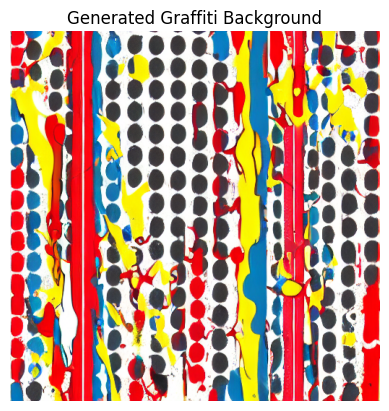

In [ ]:
# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to(device)

# Generate a textured beige graffiti background
prompt = "A textured beige background, graffiti background with bold strip-line black and red lines, yellow splashes, blue accents, scattered red dots, vibrant colors, smooth lighting"
negative_prompt = "objects, people, text, blurry, dark, dull"  # Avoid unwanted elements
image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

# Convert to OpenCV format
background_img = np.array(image)
background_img = cv2.cvtColor(background_img, cv2.COLOR_RGB2BGR)

# Resize to a standard size (e.g., 512x512)
background_img = cv2.resize(background_img, (512, 512))

# Save and display
cv2.imwrite("/content/drive/MyDrive/Thryft/background_graffiti.png", background_img)
plt.imshow(cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB))
plt.title("Generated Graffiti Background")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Successfully loaded image from /content/drive/MyDrive/Thryft/segmented_product.png
Image shape: (259, 195, 4)
Input batch shape: torch.Size([1, 3, 384, 384])
Input batch shape: torch.Size([1, 3, 384, 384])


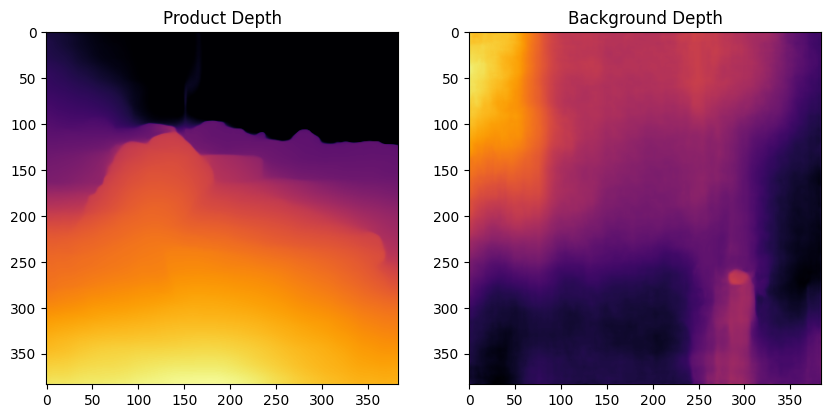

In [ ]:
# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval().to(device)

# Depth estimation function with explicit preprocessing
def get_depth_map(image):
    # Validate input
    if image is None or len(image.shape) < 3:
        raise ValueError("Invalid image input: Image is None or lacks required dimensions.")

    # Convert to RGB and resize to MiDaS expected size (e.g., 384x384)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384), interpolation=cv2.INTER_AREA)  # MiDaS works well with this size

    # Normalize to [0, 1] and convert to tensor
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).to(device)  # [C, H, W]

    # Add batch dimension: [1, C, H, W]
    input_batch = img_tensor.unsqueeze(0)
    print(f"Input batch shape: {input_batch.shape}")  # Debug shape

    # Run inference
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),  # [B, 1, H, W]
            size=img.shape[:2],       # Original height, width (384, 384 here)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    return depth_map

# Load segmented product from Google Drive
segmented_product_path = "/content/drive/MyDrive/Thryft/segmented_product.png"
segmented_product = cv2.imread(segmented_product_path, cv2.IMREAD_UNCHANGED)

# Check if image loaded
if segmented_product is None:
    raise FileNotFoundError(f"Could not load image from {segmented_product_path}. Check path and file existence.")
else:
    print(f"Successfully loaded image from {segmented_product_path}")
    print(f"Image shape: {segmented_product.shape}")

# Compute depth maps
product_depth = get_depth_map(segmented_product[:, :, :3])  # Use RGB channels
background_depth = get_depth_map(background_img)

# Display depth maps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Product Depth")
plt.imshow(product_depth, cmap='inferno')
plt.subplot(1, 2, 2)
plt.title("Background Depth")
plt.imshow(background_depth, cmap='inferno')
plt.show()

Homography computed with 10 matches.


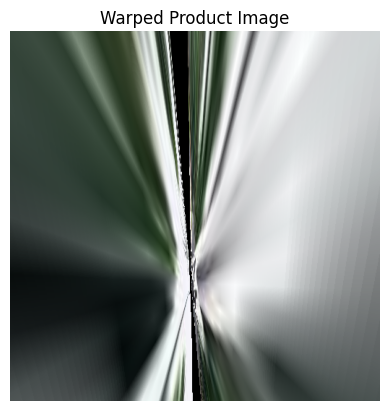

In [ ]:
# Convert images to grayscale for ORB detection
product_rgb = segmented_product[:, :, :3]  # Extract RGB channels from RGBA
product_gray = cv2.cvtColor(product_rgb, cv2.COLOR_BGR2GRAY)
background_gray = cv2.cvtColor(background_img, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(product_gray, None)
kp2, des2 = orb.detectAndCompute(background_gray, None)

# Check if keypoints and descriptors are valid
if des1 is None or des2 is None:
    print("Warning: Insufficient keypoints detected. Using identity transform.")
    H = np.eye(3)  # Fallback to identity matrix
else:
    # Match keypoints (may be sparse due to plain background)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:10]  # Limit to top 10 matches

    # Extract matched points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography (fallback to identity if insufficient matches)
    if len(matches) >= 4:
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        print(f"Homography computed with {len(matches)} matches.")
    else:
        print("Insufficient matches (< 4). Using identity transform.")
        H = np.eye(3)  # Identity matrix if homography fails

# Warp product image (including alpha channel)
h, w = background_img.shape[:2]
warped_product = cv2.warpPerspective(segmented_product, H, (w, h))

# Display warped product (convert to RGB for matplotlib)
plt.imshow(warped_product[:, :, :3][:, :, ::-1])  # Convert BGR to RGB
plt.title("Warped Product Image")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

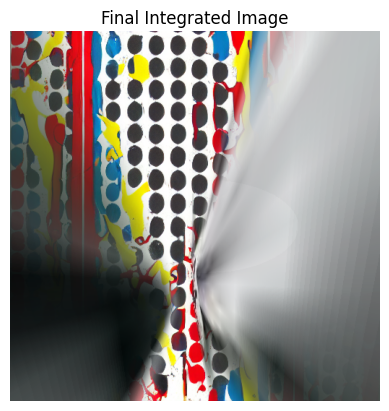

Final image saved to: /content/drive/MyDrive/Thryft/final_product_image.png


In [ ]:
# Define light source (top-left for white background)
light_direction = np.pi / 4  # 45 degrees from top-left

# Create shadow using alpha channel
mask = warped_product[:, :, 3]  # Alpha channel from warped product
shadow = np.zeros_like(background_img, dtype=np.uint8)
shift_x = int(20 * np.cos(light_direction))
shift_y = int(20 * np.sin(light_direction))

# Draw shadow as an ellipse
h, w = background_img.shape[:2]
shadow = cv2.ellipse(
    shadow,
    (w // 2 + shift_x, h // 2 + shift_y),  # Center shifted by light direction
    (mask.shape[1] // 4, mask.shape[0] // 8),  # Shadow size based on product
    0, 0, 360,  # Full ellipse
    (50, 50, 50),  # Gray color
    -1  # Filled
)

# Blend product onto background using alpha mask
blended = background_img.copy()
for c in range(3):
    blended[:, :, c] = np.where(
        warped_product[:, :, 3] > 0,  # Where alpha is non-zero
        warped_product[:, :, c],      # Use product pixel
        blended[:, :, c]              # Use background pixel
    )

# Add shadow to blended image
blended_with_shadow = cv2.addWeighted(blended, 0.9, shadow, 0.1, 0.0)

# Edge feathering with Gaussian blur
mask_blur = cv2.GaussianBlur(mask, (15, 15), 0)  # Soften edges
final_result = background_img.copy()
for c in range(3):
    final_result[:, :, c] = (
        (mask_blur / 255.0) * blended_with_shadow[:, :, c] +  # Product contribution
        ((255 - mask_blur) / 255.0) * background_img[:, :, c]  # Background contribution
    ).astype(np.uint8)

# Display final result
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.title("Final Integrated Image")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

# Save the result
output_path = "/content/drive/MyDrive/Thryft/final_product_image.png"
cv2.imwrite(output_path, final_result)
print(f"Final image saved to: {output_path}")

In [ ]:
# Import necessary libraries
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from google.colab import files
import requests
from io import BytesIO

# Install required dependencies
#!pip install git+https://github.com/huggingface/transformers.git
#!pip install torch torchvision

# Clone U^2-Net repository and add to path
#!git clone https://github.com/NathanUA/U-2-Net.git
import sys
sys.path.append('./U-2-Net')
from model import U2NET

# Download pre-trained U^2-Net weights
#!wget -O u2net.pth https://github.com/NathanUA/U-2-Net/raw/master/saved_models/u2net.pth

# Load U^2-Net model
model = U2NET()
model.load_state_dict(torch.load('u2net.pth'))
model.to('cuda')
model.eval()

# Load BLIP model and processor
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda')

# Preprocess image for U^2-Net
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to('cuda')

# Generate segmentation mask with U^2-Net
def get_mask(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        mask = output[:,0,:,:].squeeze().cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8) * 255
    return mask

# Remove and replace background
def remove_background(image_path, mask):
    image = Image.open(image_path).convert('RGBA')
    image_np = np.array(image)
    mask_resized = Image.fromarray(mask).resize(image.size, Image.BILINEAR)
    mask_np = np.array(mask_resized)
    image_np[mask_np == 0] = [255, 255, 255, 255]  # Set background to white
    return Image.fromarray(image_np)

# Generate product description with BLIP
def generate_description(processed_image):
    inputs = processor(processed_image, return_tensors="pt").to('cuda')
    out = blip_model.generate(**inputs)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

# Main function to process image and generate description
def process_and_describe(image_path):
    image_tensor = preprocess_image(image_path)
    mask = get_mask(image_tensor)
    processed_image = remove_background(image_path, mask)
    description = generate_description(processed_image)
    return processed_image, description

# Upload image in Colab
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Process and describe the image
processed_image, description = process_and_describe(image_path)

# Display results
processed_image.show()
print("Product Description:", description)

ModuleNotFoundError: No module named 'model'